# Gradient Boosting Baseline

Train XGBoost and LightGBM models on all trials with late fusion (physio + behavior + gaze).

In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style('whitegrid')
%matplotlib inline

## Load Data

In [3]:
# Load pre-extracted featureswith open('../data/results/features_POST/extracted_features_POST.pkl', 'rb') as f:    feature_data = pickle.load(f)merged_df = feature_data['merged_df']physio_cols = feature_data['physio_cols']behavior_cols = feature_data['behavior_cols']gaze_cols = feature_data['gaze_cols']print(f"✓ Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")print(f"\nFeature counts:")print(f"  Physiology: {len(physio_cols)} features")print(f"  Behavior: {len(behavior_cols)} features")print(f"  Gaze: {len(gaze_cols)} features")print(f"  Total: {len(physio_cols) + len(behavior_cols) + len(gaze_cols)} features")print(f"\nOutcome distribution:")print(merged_df['outcome'].value_counts())


✓ Loaded 12511 trials from 97 subjects

Feature counts:
  Physiology: 13 features
  Behavior: 7 features
  Gaze: 20 features
  Total: 40 features

Outcome distribution:
outcome
1    8238
0    4273
Name: count, dtype: int64


## Prepare Combined Features

In [4]:
# Impute missing values and combine features
X_physio = SimpleImputer(strategy='mean').fit_transform(merged_df[physio_cols])
X_behavior = SimpleImputer(strategy='mean').fit_transform(merged_df[behavior_cols])
X_gaze = SimpleImputer(strategy='mean').fit_transform(merged_df[gaze_cols])

# Late fusion: concatenate all features
X_combined = np.concatenate([X_physio, X_behavior, X_gaze], axis=1)
y = merged_df['outcome'].values
subjects = merged_df['subject_id'].values

print(f"Combined features shape: {X_combined.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique subjects: {len(np.unique(subjects))}")

Combined features shape: (12511, 40)
Labels shape: (12511,)
Unique subjects: 97


## XGBoost Model

In [5]:
def run_loso_xgboost(X, y, subjects):
    """
    Run LOSO cross-validation with XGBoost.
    """
    print("="*70)
    print("XGBoost Model")
    print("="*70)
    
    logo = LeaveOneGroupOut()
    
    all_y_true = []
    all_y_pred = []
    subject_accuracies = []
    
    # Calculate scale_pos_weight for class imbalance
    scale_pos_weight = (y == 0).sum() / (y == 1).sum()
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train XGBoost
        model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Store results
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        subject_accuracies.append(accuracy_score(y_test, y_pred))
    
    # Calculate metrics
    overall_acc = accuracy_score(all_y_true, all_y_pred)
    overall_f1 = f1_score(all_y_true, all_y_pred, average='weighted')
    
    print(f"\nOverall Accuracy: {overall_acc:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Mean Subject Accuracy: {np.mean(subject_accuracies):.4f} ± {stats.sem(subject_accuracies):.4f} (SEM)")
    print(f"\nClassification Report:")
    print(classification_report(all_y_true, all_y_pred))
    
    return {
        'model_name': 'XGBoost',
        'accuracy': overall_acc,
        'f1_score': overall_f1,
        'subject_accuracies': subject_accuracies,
        'y_true': all_y_true,
        'y_pred': all_y_pred
    }

results_xgb = run_loso_xgboost(X_combined, y, subjects)

XGBoost Model

Overall Accuracy: 0.6448
Overall F1 Score: 0.6524
Mean Subject Accuracy: 0.6406 ± 0.0129 (SEM)

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.61      0.54      4273
           1       0.77      0.66      0.71      8238

    accuracy                           0.64     12511
   macro avg       0.63      0.64      0.63     12511
weighted avg       0.67      0.64      0.65     12511



## LightGBM Model

In [6]:
def run_loso_lightgbm(X, y, subjects):
    """
    Run LOSO cross-validation with LightGBM.
    """
    print("="*70)
    print("LightGBM Model")
    print("="*70)
    
    logo = LeaveOneGroupOut()
    
    all_y_true = []
    all_y_pred = []
    subject_accuracies = []
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train LightGBM
        model = lgb.LGBMClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Store results
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        subject_accuracies.append(accuracy_score(y_test, y_pred))
    
    # Calculate metrics
    overall_acc = accuracy_score(all_y_true, all_y_pred)
    overall_f1 = f1_score(all_y_true, all_y_pred, average='weighted')
    
    print(f"\nOverall Accuracy: {overall_acc:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Mean Subject Accuracy: {np.mean(subject_accuracies):.4f} ± {stats.sem(subject_accuracies):.4f} (SEM)")
    print(f"\nClassification Report:")
    print(classification_report(all_y_true, all_y_pred))
    
    return {
        'model_name': 'LightGBM',
        'accuracy': overall_acc,
        'f1_score': overall_f1,
        'subject_accuracies': subject_accuracies,
        'y_true': all_y_true,
        'y_pred': all_y_pred
    }

results_lgb = run_loso_lightgbm(X_combined, y, subjects)

LightGBM Model


/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/


Overall Accuracy: 0.6498
Overall F1 Score: 0.6571
Mean Subject Accuracy: 0.6462 ± 0.0132 (SEM)

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.61      0.54      4273
           1       0.77      0.67      0.72      8238

    accuracy                           0.65     12511
   macro avg       0.63      0.64      0.63     12511
weighted avg       0.67      0.65      0.66     12511



/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Random Forest (for comparison)

In [7]:
from sklearn.ensemble import RandomForestClassifier

def run_loso_rf(X, y, subjects):
    """
    Run LOSO cross-validation with Random Forest.
    """
    print("="*70)
    print("Random Forest Model (Baseline)")
    print("="*70)
    
    logo = LeaveOneGroupOut()
    
    all_y_true = []
    all_y_pred = []
    subject_accuracies = []
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train Random Forest
        model = RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Store results
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        subject_accuracies.append(accuracy_score(y_test, y_pred))
    
    # Calculate metrics
    overall_acc = accuracy_score(all_y_true, all_y_pred)
    overall_f1 = f1_score(all_y_true, all_y_pred, average='weighted')
    
    print(f"\nOverall Accuracy: {overall_acc:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Mean Subject Accuracy: {np.mean(subject_accuracies):.4f} ± {stats.sem(subject_accuracies):.4f} (SEM)")
    print(f"\nClassification Report:")
    print(classification_report(all_y_true, all_y_pred))
    
    return {
        'model_name': 'Random Forest',
        'accuracy': overall_acc,
        'f1_score': overall_f1,
        'subject_accuracies': subject_accuracies,
        'y_true': all_y_true,
        'y_pred': all_y_pred
    }

results_rf = run_loso_rf(X_combined, y, subjects)

Random Forest Model (Baseline)

Overall Accuracy: 0.6828
Overall F1 Score: 0.6484
Mean Subject Accuracy: 0.6819 ± 0.0143 (SEM)

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.29      0.38      4273
           1       0.71      0.89      0.79      8238

    accuracy                           0.68     12511
   macro avg       0.64      0.59      0.58     12511
weighted avg       0.66      0.68      0.65     12511



## Comparison

In [8]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM'],
    'Accuracy': [results_rf['accuracy'], results_xgb['accuracy'], results_lgb['accuracy']],
    'F1_Score': [results_rf['f1_score'], results_xgb['f1_score'], results_lgb['f1_score']],
    'Mean_Subject_Acc': [
        np.mean(results_rf['subject_accuracies']),
        np.mean(results_xgb['subject_accuracies']),
        np.mean(results_lgb['subject_accuracies'])
    ],
    'SEM_Subject_Acc': [
        stats.sem(results_rf['subject_accuracies']),
        stats.sem(results_xgb['subject_accuracies']),
        stats.sem(results_lgb['subject_accuracies'])
    ]
})

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))

# Find best model
best_idx = comparison_df['Accuracy'].idxmax()
print(f"\n✓ Best model: {comparison_df.iloc[best_idx]['Model']} (Accuracy: {comparison_df.iloc[best_idx]['Accuracy']:.4f})")


MODEL COMPARISON
        Model  Accuracy  F1_Score  Mean_Subject_Acc  SEM_Subject_Acc
Random Forest  0.682839  0.648398          0.681901         0.014292
      XGBoost  0.644793  0.652387          0.640603         0.012923
     LightGBM  0.649828  0.657138          0.646152         0.013224

✓ Best model: Random Forest (Accuracy: 0.6828)


## Visualizations

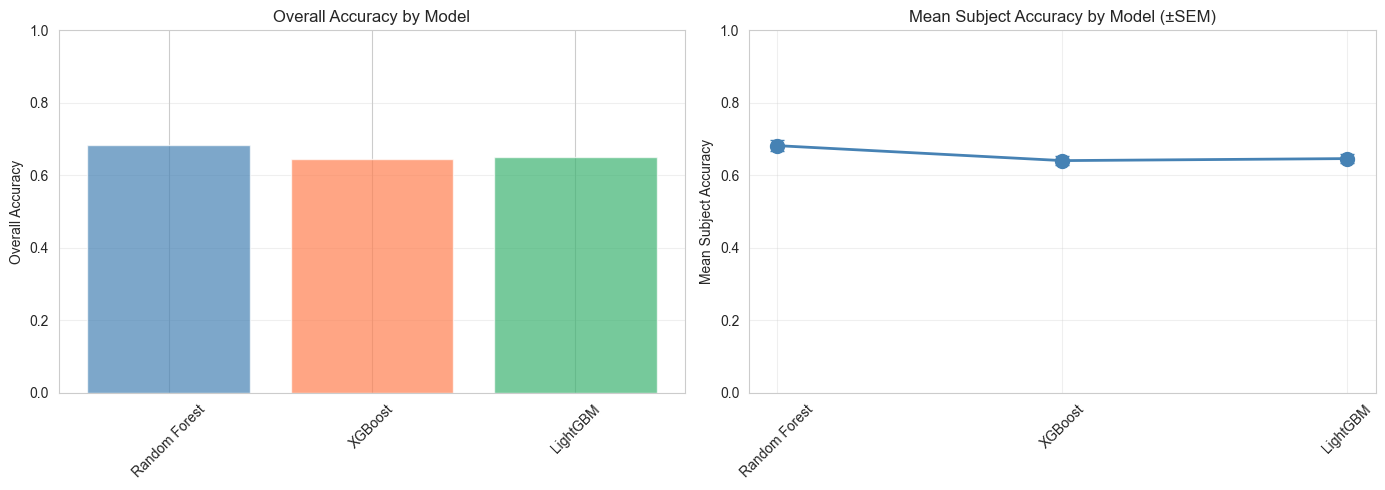

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall accuracy comparison
colors = ['steelblue', 'coral', 'mediumseagreen']
axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'], color=colors, alpha=0.7)
axes[0].set_ylabel('Overall Accuracy')
axes[0].set_title('Overall Accuracy by Model')
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Mean subject accuracy with error bars
axes[1].errorbar(comparison_df['Model'], comparison_df['Mean_Subject_Acc'],
                yerr=comparison_df['SEM_Subject_Acc'],
                marker='o', capsize=5, linewidth=2, markersize=10, color='steelblue')
axes[1].set_ylabel('Mean Subject Accuracy')
axes[1].set_title('Mean Subject Accuracy by Model (±SEM)')
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Subject Accuracy Distributions

/var/folders/rf/b27xv8554s30yymsz5rpvw340000gn/T/ipykernel_9011/2184660479.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_for_box, labels=['Random Forest', 'XGBoost', 'LightGBM'],


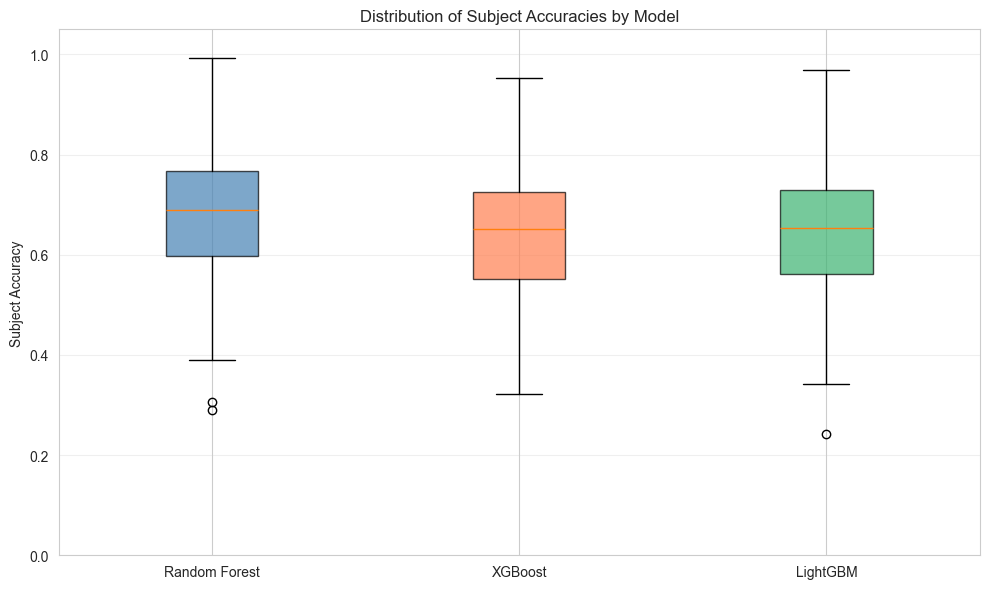

In [10]:
plt.figure(figsize=(10, 6))

data_for_box = [
    results_rf['subject_accuracies'],
    results_xgb['subject_accuracies'],
    results_lgb['subject_accuracies']
]

bp = plt.boxplot(data_for_box, labels=['Random Forest', 'XGBoost', 'LightGBM'],
                patch_artist=True)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Subject Accuracy')
plt.title('Distribution of Subject Accuracies by Model')
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Save Results

In [11]:
# Save comparison
comparison_df.to_csv('../data/results/gradient_boosting_comparison.csv', index=False)
print("✓ Saved comparison to: ../data/results/gradient_boosting_comparison.csv")

# Save detailed results
results_dict = {
    'random_forest': results_rf,
    'xgboost': results_xgb,
    'lightgbm': results_lgb
}

with open('../data/results/gradient_boosting_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)
print("✓ Saved detailed results to: ../data/results/gradient_boosting_results.pkl")

✓ Saved comparison to: ../data/results/gradient_boosting_comparison.csv
✓ Saved detailed results to: ../data/results/gradient_boosting_results.pkl
